In [1]:
import os
import sys
import requests
from dotenv import load_dotenv
from typing import Dict, Any

print(sys.path)
print(os.getcwd())

load_dotenv("/Users/paddy/Documents/Github/Dump-Truck/clash-of-clans-agent/.env")

['/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python312.zip', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/lib-dynload', '', '/Users/paddy/Documents/Github/Dump-Truck/.venv/lib/python3.12/site-packages']
/Users/paddy/Documents/Github/Dump-Truck/clash-of-clans-agent


True

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0)

# from langchain_groq import ChatGroq
# llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

from langchain_deepseek import ChatDeepSeek
llm = ChatDeepSeek(
    model="deepseek/deepseek-v3.2",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    api_base="https://openrouter.ai/api/v1",
    extra_body={"reasoning": {"enabled": True}},
)

In [3]:
# Tool Functions

BASE_URL = "https://api.clashofclans.com/v1"
TOKEN = os.getenv("CLASH_API_TOKEN")


def get_clan_details(clan_tag: str) -> Dict[str, Any]:
    """
    Fetch clan information by clan tag.
    
    Args:
        clan_tag (str): Clan tag (e.g., "#2YGRG9JCU")
    
    Returns:
        Dict[str, Any]: Clan information from the Clash of Clans API
    
    Raises:
        Exception: If API request fails (non-200 status code)
    """
    encoded_tag = clan_tag.replace("#", "%23")
    
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "Accept": "application/json"
    }
    
    response = requests.get(f"{BASE_URL}/clans/{encoded_tag}", headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API Error {response.status_code}: {response.text}")
    
    return response.json()


def get_player_details(player_tag: str) -> Dict[str, Any]:
    """
    Fetch player information by player tag.
    
    Args:
        player_tag (str): Player tag (e.g., "#ABC123")
    
    Returns:
        Dict[str, Any]: Player information from the Clash of Clans API
    
    Raises:
        Exception: If API request fails (non-200 status code)
    """
    encoded_tag = player_tag.replace("#", "%23")
    
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "Accept": "application/json"
    }
    
    response = requests.get(f"{BASE_URL}/players/{encoded_tag}", headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API Error {response.status_code}: {response.text}")
    
    return response.json()

In [4]:
tools = [get_clan_details, get_player_details]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [7]:
CLASH_OF_CLANS_SYSTEM_PROMPT = """
You are a Clash of Clans assistant who helps users with their queries 
about clans and players.

You have access to two tools:
- get_clan_details
- get_player_details

Guidelines:
- Users will generally query based on clan tags or player tags.
- Always choose the correct tool based on what the user is asking for.
- After calling a tool, analyze the returned information and answer 
  the user’s query as accurately and clearly as possible.
"""

sys_msg = SystemMessage(content=CLASH_OF_CLANS_SYSTEM_PROMPT)

In [8]:
def coc_assistant(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state["messages"])
        ]
    }


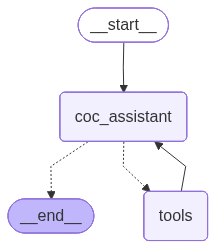

In [9]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("coc_assistant", coc_assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "coc_assistant")

builder.add_conditional_edges(
    "coc_assistant",
    tools_condition,
)

builder.add_edge("tools", "coc_assistant")


coc_graph = builder.compile()
display(Image(coc_graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [HumanMessage(content="Who is the top player in the clash of clans clan #2GJYYYJUU and also tell me some stats about that player")]
messages = coc_graph.invoke({"messages": messages})

In [11]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Who is the top player in the clash of clans clan #2GJYYYJUU and also tell me some stats about that player
================================== Ai Message ==================================
Tool Calls:
  get_clan_details (call_00_BlriffnieGNX2bzglLJEqiAN)
 Call ID: call_00_BlriffnieGNX2bzglLJEqiAN
  Args:
    clan_tag: #2GJYYYJUU
================================= Tool Message =================================
Name: get_clan_details

{"tag": "#2GJYYYJUU", "name": "Mountain Jew", "type": "inviteOnly", "description": "wars always. no disrespect in chat. everybody must join in war or else be opted out. elder will be given at 500 donations. Clan started Aug.9th 2023", "location": {"id": 32000006, "name": "International", "isCountry": false}, "isFamilyFriendly": false, "badgeUrls": {"small": "https://api-assets.clashofclans.com/badges/70/5RFuAKO0jDsuK0hluXeoULoqVp4KYPH_1-SegL97eYM.png", "large": "https://api-asset